## Lesson 14 - Twitter Graphs





### Table of Contents

* [Import Packages](#import_package)
* [Twitter API](#twitter_api)
* [Crawl Tweets and insert to Neo4j](#tweets_to_neo4j)
* [Visualize the Model](#visualize_model)
* [Plotting / Charting](#plotting)
* [Graph Algorithms](#graph_algorithms)
* [Graph Visualization](#graph_visualization)
* [Cypher query](#cypher)
* [Load Tweets from MongoDB and upload to Neo4j](#mongodb)


<a id="import_package"></a>
We're going to import Twitter data into Neo4j and then do various analysis on top of this dataset including plotting, graph algorithms, and graph visualizations.

https://github.com/nicolewhite/twitter-neo4j

### enable localhost access, or your public ip, domain name etc.
<img src="images/neo4j_enable_localhost.png">

## Packages

In [1]:
import os
import sys
import time
import datetime
import requests
import py2neo
from urllib.parse import quote, unquote
from pymongo import MongoClient
from pymongo import UpdateOne
# pip install py2neo==5.0b1
# pip install py2neo==2021.1.5
from py2neo import Graph, Node, Relationship, NodeMatcher, RelationshipMatcher
print(py2neo.__version__)

5.0b1


In [2]:
# http://127.0.0.1:7474/browser/
graph = Graph('http://127.0.0.1:7474', username='neo4j', password='')

# graph = Graph("bolt://localhost:7687", auth=("neo4j", "42840667"))
transaction = graph.begin()

### Create CONSTRAINT

In [3]:
graph.run("CREATE CONSTRAINT ON (u:User) ASSERT u.username IS UNIQUE")
graph.run("CREATE CONSTRAINT ON (t:Tweet) ASSERT t.id IS UNIQUE")
graph.run("CREATE CONSTRAINT ON (h:Hashtag) ASSERT h.name IS UNIQUE")

### Delete CONSTRAINT

In [ ]:
# graph.run("DROP CONSTRAINT ON (u:User) ASSERT u.username IS UNIQUE")
# graph.run("DROP CONSTRAINT ON (t:Tweet) ASSERT t.id IS UNIQUE")
# graph.run("DROP CONSTRAINT ON (h:Hashtag) ASSERT h.name IS UNIQUE")

<a id="twitter_api"></a>
## Twitter API

The Twitter API provides the tools you need to contribute to, engage with, and analyze the conversation happening on Twitter.

https://developer.twitter.com/en/docs/twitter-api

In [4]:
from __future__ import print_function

import base64
import requests
import urllib.parse

OAUTH2_TOKEN = 'https://api.twitter.com/oauth2/token'

# https://developer.twitter.com/en/docs/basics/authentication/oauth-2-0/bearer-tokens
def get_bearer_token(consumer_key, consumer_secret):
    # enconde consumer key
    consumer_key = urllib.parse.quote(consumer_key)
    # encode consumer secret
    consumer_secret = urllib.parse.quote(consumer_secret)
    # create bearer token
    bearer_token = consumer_key + ':' + consumer_secret
    # base64 encode the token
    base64_encoded_bearer_token = base64.b64encode(bearer_token.encode('utf-8'))
    # set headers
    headers = {
        "Authorization": "Basic " + base64_encoded_bearer_token.decode('utf-8') + "",
        "Content-Type": "application/x-www-form-urlencoded;charset=UTF-8",
        "Content-Length": "29"}

    response = requests.post(OAUTH2_TOKEN, headers=headers, data={'grant_type': 'client_credentials'})
    to_json = response.json()
    print("token_type = %s\naccess_token  = %s" % (to_json['token_type'], to_json['access_token']))
    return to_json['access_token']

### Change consumer_key & consumer_secret

In [1]:
# https://developer.twitter.com/en/apps
consumer_key = ''
consumer_secret = ''
TWITTER_BEARER = get_bearer_token(consumer_key, consumer_secret)

In [6]:
headers = dict(accept="application/json", Authorization="Bearer " + TWITTER_BEARER)
base_url = "https://api.twitter.com/1.1/search/tweets.json?"

### Find Tweets

The maximum number of requests that are allowed is based on a time interval, some specified period or window of time. The most common request limit interval is fifteen minutes. If an endpoint has a rate limit of 900 requests/15-minutes, then up to 900 requests over any 15-minute interval is allowed. 

https://developer.twitter.com/en/docs/twitter-api/v1/rate-limits

In [7]:
# https://developer.twitter.com/en/docs/tweets/search/api-reference/get-search-tweets

query_params = {'query': '(from:twitterdev -is:retweet) OR #twitterdev','tweet.fields': 'author_id'}

def find_tweets(q, lang, max_id):
    payload = dict(
        count=100,
        result_type="recent",
        lang=lang,
        q=quote(q),
        # since='2021-01-01',
        max_id = max_id
    )
    url = base_url + "q={q}&count={count}&result_type={result_type}&lang={lang}&max_id={max_id}".format(**payload)
    print(url)
    r = requests.get(url, headers=headers)
    tweets = r.json()["statuses"]
    return tweets

In [9]:
max_id = -1
until = "2021-09-17"
query = "魷魚遊戲"
lang = 'zh'
tweets = find_tweets(q=query, lang=lang, max_id=max_id)

https://api.twitter.com/1.1/search/tweets.json?q=%E9%AD%B7%E9%AD%9A%E9%81%8A%E6%88%B2&count=100&result_type=recent&lang=zh&max_id=-1


In [10]:
client = MongoClient("mongodb://127.0.0.1:27017")
collection_name = 'twitter'
db = client[collection_name]
post_collection_name = "tweets"

In [11]:
operations = []
for t in tweets[:10]:
    key = {"id":t["id"]}
    operations.append(
                       UpdateOne(key,{ "$set": t }, upsert=True)
                     )
    u = t["user"]
    e = t["entities"]
    for m in e.get('user_mentions', []):
        print(m)
    max_id = t["id"]
if operations:
    result = db[post_collection_name].bulk_write(operations, ordered=False)
print(max_id)

{'screen_name': 'zhanglucy88', 'name': 'LUCY', 'id': 821030674270330880, 'id_str': '821030674270330880', 'indices': [3, 15]}
{'screen_name': 'zhanglucy88', 'name': 'LUCY', 'id': 821030674270330880, 'id_str': '821030674270330880', 'indices': [3, 15]}
{'screen_name': 'Duby_1125', 'name': '嘟比Duby💫Dreamcity 新人Vtuber準備中WEE', 'id': 1432285359157563395, 'id_str': '1432285359157563395', 'indices': [3, 13]}
{'screen_name': 'zhanglucy88', 'name': 'LUCY', 'id': 821030674270330880, 'id_str': '821030674270330880', 'indices': [3, 15]}
{'screen_name': 'zhanglucy88', 'name': 'LUCY', 'id': 821030674270330880, 'id_str': '821030674270330880', 'indices': [3, 15]}
{'screen_name': 'midwaydude', 'name': '喵流青年', 'id': 2845909596, 'id_str': '2845909596', 'indices': [3, 14]}
1451443977647898625


<a id="tweets_to_neo4j"></a>
## Crawl Tweets and insert to Neo4j

In [12]:
def convert_twitter_time(tsc):
    ts = time.strftime('%Y-%m-%d %H:%M:%S', time.strptime(tsc,'%a %b %d %H:%M:%S +0000 %Y'))
    ts = datetime.datetime.strptime(ts, '%Y-%m-%d %H:%M:%S')+datetime.timedelta(hours=+8)
    return ts.strftime("%Y-%m-%d %H:%M:%S")

def upload_tweets(tweets):
    for t in tweets:
        u = t["user"]
        e = t["entities"]

        # 利用 Dictionary來建立 Node 物件
        tw_dict = {'id':t['id'], 'text':t['text'], 'created':convert_twitter_time(t['created_at']),
                   'rts':t['retweet_count'],
                   'favs':t['favorite_count'], 'lang':t['lang']}
        tweet = Node("Tweet", **tw_dict)
        #tweet = Node("Tweet", id=t["id"])
        tweet.__primarylabel__ = "Tweet"
        tweet.__primarykey__ = "id"
        graph.merge(tweet)

        transaction.graph.push(tweet)

        user = Node("User", username=u["screen_name"])
        user.__primarylabel__ = "User"
        user.__primarykey__ = "username"
        graph.merge(user)

        graph.merge(Relationship(user, "POSTS", tweet))

        for h in e.get("hashtags", []):
            hashtag = Node("Hashtag", name=h["text"].lower())
            hashtag.__primarylabel__ = "Hashtag"
            hashtag.__primarykey__ = "name"
            graph.merge(hashtag)
            graph.merge(Relationship(hashtag, "TAGS", tweet))

        for m in e.get('user_mentions', []):
            mention = Node("User", username=m["screen_name"])
            mention.__primarylabel__ = "User"
            mention.__primarykey__ = "username"
            graph.merge(mention)
            graph.merge(Relationship(tweet, "MENTIONS", mention))

        reply = t.get("in_reply_to_status_id")

        if reply:
            reply_tweet = Node("Tweet", id=reply)
            reply_tweet.__primarylabel__ = "Tweet"
            reply_tweet.__primarykey__ = "id"
            graph.merge(reply_tweet)
            graph.merge(Relationship(tweet, "REPLY_TO", reply_tweet))

        ret = t.get("retweeted_status", {}).get("id")

        if ret:
            retweet = Node("Tweet", id=ret)
            retweet.__primarylabel__ = "Tweet"
            retweet.__primarykey__ = "id"
            graph.merge(retweet)
            graph.merge(Relationship(tweet, "RETWEETS", retweet))

### Upload first api data to neo4j

In [13]:
since_id = tweets[0].get("id")
upload_tweets(tweets)

print("Test is done.")

Test is done.


### Checking neo4j nodes
<img src="images/twitter_test_nodes.png">

In [14]:
client = MongoClient("mongodb://127.0.0.1:27017")
collection_name = 'twitter'
db = client[collection_name]
post_collection_name = "tweets"

In [15]:
# Query by start date
since_date_str = "2021-09-17 00:00:00"
since_date = datetime.datetime.strptime(since_date_str, '%Y-%m-%d %H:%M:%S')
max_id = -1
query = "魷魚遊戲"
lang = 'zh'

while True:
    try:
        tweets = find_tweets(q=query, lang=lang, max_id=max_id)

        if not tweets:
            print("No tweets found.")
            time.sleep(1)
            #continue
            break

        reach_date_limit = False
        operations = []
        since_id = tweets[-1].get("id")
        tweets_query_list = list(db[post_collection_name].find({"id":since_id}))
        if len(tweets_query_list)>0:
            reach_date_limit = True
        for tweet in tweets:
            max_id = tweet["id"]
            created_at_str = convert_twitter_time(tweet["created_at"])
            #print(created_at_str)
            created_at_date = datetime.datetime.strptime(created_at_str, '%Y-%m-%d %H:%M:%S')
            key = {"id":tweet["id"]}
            operations.append(
                               UpdateOne(key,{ "$set": tweet }, upsert=True)
                             )
            if(created_at_date<since_date):
                reach_date_limit = True
        if operations:
            result = db[post_collection_name].bulk_write(operations, ordered=False)
        upload_tweets(tweets)
        print("{} tweets uploaded!".format(len(tweets)))
        
        if reach_date_limit:
            break
        time.sleep(1)

    except Exception as e:
        print(e)
        time.sleep(1)
        continue

https://api.twitter.com/1.1/search/tweets.json?q=%E9%AD%B7%E9%AD%9A%E9%81%8A%E6%88%B2&count=100&result_type=recent&lang=zh&max_id=-1
84 tweets uploaded!
https://api.twitter.com/1.1/search/tweets.json?q=%E9%AD%B7%E9%AD%9A%E9%81%8A%E6%88%B2&count=100&result_type=recent&lang=zh&max_id=1451212020179603463
54 tweets uploaded!
https://api.twitter.com/1.1/search/tweets.json?q=%E9%AD%B7%E9%AD%9A%E9%81%8A%E6%88%B2&count=100&result_type=recent&lang=zh&max_id=1451107126953140226
68 tweets uploaded!
https://api.twitter.com/1.1/search/tweets.json?q=%E9%AD%B7%E9%AD%9A%E9%81%8A%E6%88%B2&count=100&result_type=recent&lang=zh&max_id=1450924867352612864
54 tweets uploaded!
https://api.twitter.com/1.1/search/tweets.json?q=%E9%AD%B7%E9%AD%9A%E9%81%8A%E6%88%B2&count=100&result_type=recent&lang=zh&max_id=1450818596511223813
84 tweets uploaded!
https://api.twitter.com/1.1/search/tweets.json?q=%E9%AD%B7%E9%AD%9A%E9%81%8A%E6%88%B2&count=100&result_type=recent&lang=zh&max_id=1450731323476246531
55 tweets uploade

<a id="mongodb"></a>
## Load Tweets from MongoDB and upload to Neo4j

In [16]:
client = MongoClient("mongodb://127.0.0.1:27017")
collection_name = 'twitter'
db = client[collection_name]
post_collection_name = "tweets"

In [17]:
tweets = []
tweets_list = list(db[post_collection_name].find({}))
for tweet in tweets_list:
    if '_id' in tweet:
        del tweet['_id']
    tweets.append(tweet)
upload_tweets(tweets)

<a id="visualize_model"></a>
## Visualize the Model

In [18]:
# https://github.com/merqurio/neo4jupyter
import neo4jupyter
neo4jupyter.init_notebook_mode()

options = {"User": "username", "Hashtag": "name"}
neo4jupyter.draw(graph, options, physics=True, limit=30)

<IPython.core.display.Javascript object>

<a id="plotting"></a>
## Plotting

Let's gather some basic insights by creating plotly charts.

### Packages

In [19]:
import matplotlib 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.font_manager import FontProperties

# Windows
myfont = FontProperties(fname=r'C:\Windows\Fonts\kaiu.ttf',size=14)

# Mac OS
#myfont = FontProperties(fname="/Users/mac/Library/Fonts/NotoSansHant-Medium.otf", size=14)

sns.set(font=myfont.get_name())

plt.style.use('fivethirtyeight')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

### What are the top hashtags?

Find hashtags ordered by the number of tweets they've tagged.

In [20]:
cypher = '''MATCH (hashtag:Hashtag)-[:TAGS]->(tweet:Tweet)         \
            WHERE hashtag.name <> 'rstats'                         \
            RETURN hashtag.name AS hashtag, count(tweet) AS tweets \
            ORDER BY tweets DESC LIMIT 10'''
df = graph.run(cypher).to_data_frame()
df.head()

,hashtag,tweets
0,魷魚遊戲,47
1,쯔위,38
2,tzuyu,38
3,ツウィ,38
4,子瑜,38


In [21]:
df.shape[0]

10

D:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 52180 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 50948 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 50724 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 51669 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 50612 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 44172 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Anaconda3\lib\site-

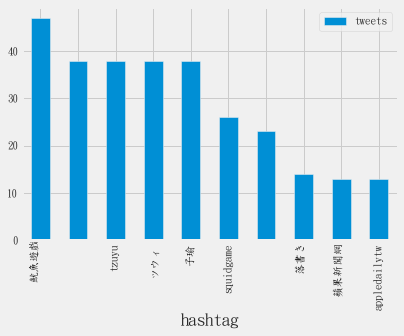

In [22]:
df.plot(kind='bar', x='hashtag', y='tweets')

### What's the hashtag and mention count distribution?

In [23]:
cypher = '''MATCH (tweet:Tweet)                                   \
            RETURN tweet.id,                                      \
            size((:Hashtag)-[:TAGS]->(tweet)) AS hashtags,        \
            size((tweet)-[:MENTIONS]->(:User)) AS mentions'''
            
df = graph.run(cypher).to_data_frame()
if 'tweet.id' in df.columns:
    del df["tweet.id"]
df.head()

,hashtags,mentions
0,0,1
1,0,0
2,0,1
3,0,1
4,0,0


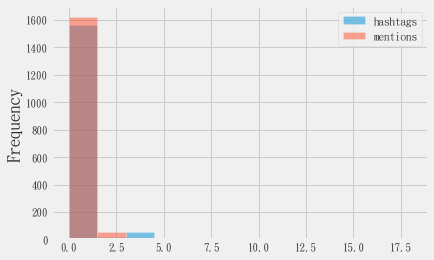

In [24]:
ax = df.plot.hist(bins=12, alpha=0.5)

### Heatmap of hashtag co-occurrence

In [25]:
cypher = '''MATCH (h:Hashtag)                           \
            WHERE h.name <> "rstats"                    \
            WITH h, size((h)-[:TAGS]->(:Tweet)) AS tags \
            ORDER BY tags DESC                          \
            LIMIT 15                                    \
                                                        \
            WITH collect(h) AS top_hash                 \
            UNWIND top_hash AS h1                       \
            UNWIND top_hash AS h2                       \
                                                        \
            MATCH (h1)-[:TAGS]->(:Tweet)<-[:TAGS]-(h2)  \
            WHERE h1.name < h2.name                     \
            RETURN h1.name, h2.name, count(*) AS weight'''
            
df = graph.run(cypher).to_data_frame()
df.head()

,h1.name,h2.name,weight
0,魷魚遊戲,오징어게임,23
1,ツウィ,쯔위,38
2,ツウィ,子瑜,38
3,tzuyu,쯔위,38
4,tzuyu,ツウィ,38


In [26]:
tp = df.corr()
tp

,weight
weight,1.000


In [27]:
# sns.heatmap(tp)

<a id="graph_algorithms"></a>
## Graph Algorithms

The typical workflow consists of retrieving a subgraph from Neo4j via Cypher and analyzing this graph in igraph.

### A subgraph of users retweeting other users

In [28]:
query = """
MATCH (user1:User)-[:POSTS]->(retweet:Tweet)-[:RETWEETS]->(tweet:Tweet),
      (user2:User)-[:POSTS]->(tweet)
RETURN user1.username, user2.username, count(*) AS weight
"""

df = graph.run(query).to_data_frame()
df.head()

,user1.username,user2.username,weight
0,grownupin40s,zhanglucy88,1
1,N8LzKh8C4jQ38Af,zhanglucy88,1
2,Yei_Yui,Duby_1125,1
3,MAXWANG55426194,zhanglucy88,1
4,Dan16774245,zhanglucy88,1


In [29]:
# pip install python-igraph
from igraph import Graph as IGraph

data = graph.run(query)
ig = IGraph.TupleList(data, weights=True)
ig

### Which users have the highest betweenness?

The betweenness centrality of a node v is the number of shortest paths that pass through v, σst(v), divided by the total number of shortest paths, σst.

brandes於 2001 年提出的演算法 "A faster algorithm for betweenness centrality"，在無權圖上複雜度為O(mn), 在有權圖上複雜度在O(mn+nlogn), 在網路稀疏的時候，複雜度接近O(n2).

betweenness(v) = ∑s, t∈Vσst(v)σst

其中σst(v)表示經過節點v的s→t的最短路徑條數,σst表示s→t的最短路徑條數。

直觀上來說，betweenness反映了節點v作為“橋樑”的重要程度。

In [30]:
between = [(node["name"], node.betweenness()) for node in ig.vs]
top = sorted(between, key=lambda x: x[1], reverse=True)
top[:5]

[('Peacefu15688441', 12681.333333333341),
 ('TAIWANLorraine', 8588.5),
 ('Trump2090173924', 7319.0),
 ('midwaydude', 5216.833333333332),
 ('chen_yenhan', 4944.0)]

### Which users have the highest betweenness?

betweenness(v)=∑s,t∈Vσst(v)σst 

The betweenness centrality of a node  v  is the number of shortest paths that pass through  v ,  σst(v) , divided by the total number of shortest paths,  σst .

In [31]:
between = [(node["name"], node.betweenness()) for node in ig.vs]
top = sorted(between, key=lambda x: x[1], reverse=True)
top[:5]

[('Peacefu15688441', 12681.333333333341),
 ('TAIWANLorraine', 8588.5),
 ('Trump2090173924', 7319.0),
 ('midwaydude', 5216.833333333332),
 ('chen_yenhan', 4944.0)]

### Which users have the highest closeness?

closeness(v)=1∑xd(v,x) 

The closeness centrality is the reciprocal of a node's farness, or sum of its shortest path distances from all other nodes in the graph.

In [32]:
close = [(node["name"], node.closeness()) for node in ig.vs]
top = sorted(close, key=lambda x: x[1], reverse=True)
top[:5]

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: closeness centrality is not well-defined for disconnected graphs at c:\projects\python-igraph-jst2e\vendor\build\igraph\igraph-0.9.0-pre+0afacadd-msvc\src\centrality.c:2856
  """Entry point for launching an IPython kernel.


[('Peacefu15688441', 0.0032707066075017195),
 ('Trump2090173924', 0.003269383738017877),
 ('Zoe23605051', 0.0032683702625478464),
 ('TAIWANLorraine', 0.0032679738562091504),
 ('Samhon852', 0.0032678417421302284)]

### Community detection

In [33]:
clusters = IGraph.community_walktrap(ig, weights="weight")
clusters = clusters.as_clustering()
len(clusters)

68

In [34]:
nodes = [{"id": node.index, "label": node["name"]} for node in ig.vs]

for node in nodes:
    node["group"] = clusters.membership[node["id"]]
    
nodes[:5]

[{'id': 0, 'label': 'grownupin40s', 'group': 0},
 {'id': 1, 'label': 'zhanglucy88', 'group': 0},
 {'id': 2, 'label': 'N8LzKh8C4jQ38Af', 'group': 0},
 {'id': 3, 'label': 'Yei_Yui', 'group': 1},
 {'id': 4, 'label': 'Duby_1125', 'group': 1}]

In [35]:
edges = [{"from": x[0], "to": x[1]} for x in ig.get_edgelist()]
edges[:5]

[{'from': 0, 'to': 1},
 {'from': 1, 'to': 2},
 {'from': 3, 'to': 4},
 {'from': 1, 'to': 5},
 {'from': 1, 'to': 6}]

In [36]:
neo4jupyter.vis_network(nodes, edges, physics=True)

<a id="graph_visualization"></a>
## Graph Visualization

### jgraph

In [37]:
# pip install jgraph
import jgraph

query = """
MATCH (user1:User)-[:POSTS]->(:Tweet)-[:RETWEETS|REPLY_TO]->(:Tweet)<-[:POSTS]-(user2:User)
RETURN ID(user1), ID(user2)
"""

data = graph.run(query)
tup = [tuple(x) for x in data]

jgraph.draw(tup)

<a id="cypher"></a>
## Cypher

### TOP MENTIONS OF User

TOP MENTIONS OF YOU

```python
MATCH
  (u:User)-[:POSTS]->(t:Tweet)-[:MENTIONS]->(m:User {screen_name:''})
WHERE 
  u.screen_name <> ''
RETURN
  u.screen_name AS screen_name, COUNT(u.screen_name) AS count 
ORDER BY 
  count 
DESC LIMIT 10
```

### FOLLOWBACK RATE
```
MATCH (me:User {screen_name: ''})-[:FOLLOWS]->(f)
WITH me, f, size((f)-[:FOLLOWS]->(me)) as doesFollowBack
RETURN sum(doesFollowBack) / toFloat(count(f))  AS followBackRate
```

### LINKS FROM INTERESTING RETWEETS
```
MATCH (:User {screen_name: ''})-[:POSTS]->
  (t:Tweet)-[:RETWEETS]->(rt)-[:CONTAINS]->(link:Link)
RETURN t.id_str AS tweet, link.url AS url, rt.favorites AS favorites
ORDER BY favorites DESC LIMIT 10
```

### MOST TAGGED BY User
```
MATCH
  (h:Hashtag)<-[:TAGS]-(t:Tweet)<-[:POSTS]-(u:User {screen_name:''})
WITH 
  h, COUNT(h) AS Hashtags
ORDER BY 
  Hashtags DESC
LIMIT 10
RETURN 
  h.name, Hashtags
```

### USERS TWEETING ABOUT YOU, BUT YOU DON'T FOLLOW
```
MATCH (ou:User)-[:POSTS]->(t:Tweet)-[mt:MENTIONS]->(me:User {screen_name: ''})
WITH DISTINCT ou, me
WHERE (ou)-[:FOLLOWS]->(me)
AND NOT (me)-[:FOLLOWS]->(ou)
RETURN ou.screen_name
LIMIT 20
```

### USERS TWEETING WITH COMMON TAGS AS YOU
```
MATCH (me:User {screen_name:''})-[:POSTS]->(tweet:Tweet)-[:TAGS]->(ht)
OPTIONAL MATCH (tweet)<-[:RETWEETS]-(retweet)
WITH me,ht, collect(distinct retweet) as retweets
MATCH (ht)<-[:TAGS]-(tweet2:Tweet)<-[:POSTS]-(sugg:User)
WHERE sugg <> me and NOT(tweet2 IN retweets)
WITH sugg, count(distinct(ht)) as common
RETURN sugg.screen_name as friend, common
ORDER BY common DESC
LIMIT 20
```

## Summary

We now import Twitter data into Neo4j and generate various analysis on top of this dataset including plotting, graph algorithms, and graph visualizations.